In [35]:
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn           as sns
import matplotlib.pyplot as plt

from xgboost                 import XGBClassifier

from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import make_scorer, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler , RobustScaler


import inflection
import shap

In [36]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    accent = lambda x: inflection.transliterate(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_old = list(map(accent, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df



In [37]:
# Dados de Treino
df_train      = pd.read_csv('base/train.csv')
df_raw        = pd.read_csv('base/train.csv')

# Dados de Teste
df_test       = pd.read_csv('base/test.csv')

# # Modelo de Submissão
df_submission = pd.read_csv('base/submission.csv', sep=';')

In [38]:
df_train = rename_columns(df_train)
df_test = rename_columns(df_test)

In [39]:
colunas_replace = ['in_store_wifi', 'open/close_time_convenient', 'easy_of_online_shopping',
                      'toilet_cleaning', 'dressing_room', 'waiting_room', 'kids_entertainment',
                      'seller_service', 'showroom', 'self_store', 'purchase_service',
                      'store_service', 'cleanliness'
                     ]

df_train[colunas_replace] = df_train[colunas_replace].replace(0, -999)

In [40]:
# Encoding a variavel target
df_train['satisfaction'] = df_train['satisfaction'].replace({'Satisfied': 1, 'Neutral or Dissatisfaction': 0})

catbin_vars = ['gender', 'customer_type', 'type_of_purchase']

le = LabelEncoder()
df_train[catbin_vars] = df_train[catbin_vars].apply(le.fit_transform)

# Encoding a variavel
lo = OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])
df_train['store_size'] = lo.fit_transform(df_train['store_size'].values.reshape(-1, 1))

satisfaction
0    0.566667
1    0.433333
Name: proportion, dtype: float64

In [41]:
df_train[df_train['carrier_delay_in_minutes'] > 10]['satisfaction'].value_counts(normalize=True)

satisfaction
0    0.623021
1    0.376979
Name: proportion, dtype: float64

In [42]:
df_train['delivery_delay_in_minutes'].mean()

15.178678301832152

In [9]:
# df_train['carrier_delay_in_minutes'] = np.log1p(df_train['carrier_delay_in_minutes'])
# df_train['delivery_delay_in_minutes'] = np.log1p(df_train['delivery_delay_in_minutes'])
# df_train['store_distance'] = np.log1p(df_train['store_distance'])



# df_train['grupo1'] = df_train['in_store_wifi'] + df_train['self_store'] + df_train['store_service'] + df_train['purchase_service'] + df_train['seller_service'] + df_train['kids_entertainment'] + df_train['store_location']
# df_train['grupo2'] = df_train['open/close_time_convenient'] + df_train['dressing_room'] + df_train['waiting_room']
# df_train['grupo3'] = df_train['cleanliness'] + df_train['toilet_cleaning'] + df_train['waiting_room']


# bins = [0, 18, 35, 50, float('inf')]  # Faixas etárias
# labels = ['1', '2', '3', '4']  # Rótulos para cada faixa etária
# df_train['age_category'] = pd.cut(df_train['age'], bins=bins, labels=labels)

In [43]:
df_train

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,1,0,13,1,0.0,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,0
1,5047,1,1,25,0,2.0,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,0
2,110028,0,0,26,0,2.0,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,24026,0,0,25,0,2.0,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,119299,1,0,61,0,2.0,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,0,1,23,0,1.0,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,0
103900,73097,1,0,49,0,2.0,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,1
103901,68825,1,1,30,0,2.0,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,0
103902,54173,0,1,22,0,1.0,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,0


In [44]:
df_train.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'in_store_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [11]:
# Separação das variáveis independentes e dependente
X = df_train.drop(['satisfaction','id','delivery_delay_in_minutes', 'carrier_delay_in_minutes'], axis=1)
y = df_train['satisfaction'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [12]:
# variáveis categóricas
cat_columns = list(X.select_dtypes(include=['object']).columns)

# variáveis numéricas
num_columns  = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [13]:
# pipeline variáveis cateǵoricas
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                     ("ohe"        , OneHotEncoder(handle_unknown="ignore"))])

# pipeline variáveis numéricas
num_pipe = Pipeline([("num_imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                     ("outliers"   , RobustScaler()),
                     ("scaler"     , StandardScaler())])

# data preparation
preprocessing = ColumnTransformer([("categorica", cat_pipe, cat_columns),
                                   ("numerica", num_pipe, num_columns)])

In [14]:
# pipeline para treinamento
pipe = Pipeline([("preprocessing", preprocessing),
                 ("xgb", XGBClassifier())])

# Treino

In [15]:
# hiperparâmetros
xgb_hyperparams = {"xgb__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
                   "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ], 
                   "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
                   "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "xgb__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] }

# métricas
f1_macro          = make_scorer(f1_score, average="macro")
precision         = make_scorer(precision_score)
recall            = make_scorer(recall_score)
accuracy          = make_scorer(accuracy_score)

scoring_dict = {'f1_macro'          : f1_macro,
                'precision'         : precision,
                'recall'            : recall,
                'accuracy'          : accuracy}

In [16]:
# Randomized Scearch Cross Validation
rscv = RandomizedSearchCV(estimator=pipe,
                          param_distributions=xgb_hyperparams,
                          n_iter = 10,
                          scoring = scoring_dict,
                          refit = 'precision',
                          n_jobs = -1,
                          cv = 5,
                          random_state=42)

In [17]:
# Resultado considerando a métrica principal (precision)
result = rscv.fit(X_train, y_train)

print(f'Os melhores parâmetros foram:\n{result.best_params_}')

print(f'\nA melhor média de precision foi: {result.best_score_}')

Os melhores parâmetros foram:
{'xgb__min_child_weight': 1, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}

A melhor média de precision foi: 0.9642620558814382


In [18]:
# Pipeline do melhor resultado
result.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  []),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   RobustScaler()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sto...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [19]:
# Resultado com todas as métricas observadas
df_result = pd.DataFrame(result.cv_results_)

# Selecionando apenas algumas das colunas
df_result[['rank_test_f1_macro',
           'mean_test_f1_macro',
           'std_test_f1_macro',
           'mean_test_precision',
           'std_test_precision',
           'mean_test_recall',
           'std_test_recall',
           'mean_test_accuracy',
           'std_test_accuracy']].sort_values('rank_test_f1_macro').head()

,rank_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy
6,1,0.954746,0.002072,0.961642,0.003200,0.934976,0.001742,0.955716,0.002036
9,2,0.953858,0.002077,0.963434,0.002952,0.931092,0.002675,0.954881,0.002032
7,3,0.952834,0.001781,0.964262,0.002794,0.927889,0.001789,0.953906,0.001748
1,4,0.952410,0.002994,0.962087,0.004077,0.929105,0.003006,0.953470,0.002934
3,5,0.950541,0.001737,0.957372,0.002325,0.929580,0.001893,0.951609,0.001702


In [20]:
# Treino com o melhor pipeline
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

# Predição para dados nunca vistos
y_hat = model.predict(X_test)

# Métrica para dados não vistos pelo modelo
print(f'O f1-score foi: {f1_score(y_test, y_hat)}')
print(f'A precisão foi: {precision_score(y_test, y_hat)}')
print(f'O recall  foi:  {recall_score(y_test, y_hat)}')
print(f'A acurácia foi: {accuracy_score(y_test, y_hat)}')

O f1-score foi: 0.9454020395271185
A precisão foi: 0.9643744821872411
O recall  foi:  0.9271616957252854
A acurácia foi: 0.9534185401909455


In [21]:
X_test1 = X_test.copy()

X_test1['satisfaction'] = y_test
X_test1['p'] = y_hat

X_test1.head()

,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,satisfaction,p
80638,0,0,26,1,1.0,861,2,4,2,5,...,5,5,5,4,4,3,5,5,0,0
43398,1,0,22,0,2.0,393,3,5,5,5,...,3,3,1,1,3,2,3,3,0,0
32751,0,0,59,1,1.0,196,1,3,1,3,...,3,4,4,1,4,3,4,4,0,0
33571,0,0,32,1,1.0,1020,2,3,2,4,...,4,4,3,2,4,1,4,4,0,0
71287,1,1,35,0,2.0,1117,2,2,2,1,...,5,2,2,2,3,2,2,2,0,0


In [22]:
erros = X_test1[X_test1['satisfaction'] != X_test1['p']].sort_values(['satisfaction', 'p'])
erros

,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,satisfaction,p
60660,0,0,49,0,1.0,551,4,1,1,1,...,3,4,4,4,4,2,4,1,0,1
47572,1,1,39,0,2.0,2583,4,5,5,4,...,5,5,2,4,5,5,3,5,0,1
72532,1,0,77,0,0.0,821,4,5,5,5,...,4,4,4,5,3,1,2,4,0,1
31306,1,0,30,0,0.0,882,4,1,1,1,...,4,4,3,5,3,2,2,4,0,1
6667,1,1,16,0,1.0,507,4,-999,4,1,...,3,3,4,4,5,4,5,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1,0,37,0,0.0,489,4,1,1,1,...,4,4,4,3,4,1,3,4,1,0
42289,1,0,53,1,1.0,1037,4,2,4,3,...,4,5,1,3,2,3,3,5,1,0
9736,0,1,38,0,1.0,101,4,4,4,5,...,3,3,4,2,5,2,3,3,1,0
36915,0,0,15,1,2.0,200,4,3,4,1,...,1,1,3,1,1,3,3,1,1,0


In [23]:
erros_0 = erros[erros['satisfaction'] == 0]
erros_1 = erros[erros['satisfaction'] == 1]

In [24]:
erros_1

,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,satisfaction,p
34023,1,1,40,0,2.0,235,3,3,3,3,...,4,3,2,2,2,3,1,3,1,0
8805,1,0,44,0,1.0,109,3,1,4,1,...,3,3,3,1,2,3,1,3,1,0
101452,1,0,41,0,1.0,801,3,5,5,5,...,3,3,5,5,2,2,2,3,1,0
36162,1,1,20,0,1.0,1009,4,4,4,4,...,3,3,5,5,4,5,4,3,1,0
56923,1,0,9,1,1.0,452,4,5,4,3,...,2,2,2,3,3,5,3,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1,0,37,0,0.0,489,4,1,1,1,...,4,4,4,3,4,1,3,4,1,0
42289,1,0,53,1,1.0,1037,4,2,4,3,...,4,5,1,3,2,3,3,5,1,0
9736,0,1,38,0,1.0,101,4,4,4,5,...,3,3,4,2,5,2,3,3,1,0
36915,0,0,15,1,2.0,200,4,3,4,1,...,1,1,3,1,1,3,3,1,1,0


In [25]:
erros_1['store_service'].value_counts()

store_service
4    301
3    196
5    161
2    111
1     54
Name: count, dtype: int64

In [26]:
erros_1['type_of_purchase'].value_counts()

type_of_purchase
0    530
1    293
Name: count, dtype: int64

In [27]:
erros_1['store_size'].value_counts()

store_size
1.0    548
2.0    182
0.0     93
Name: count, dtype: int64

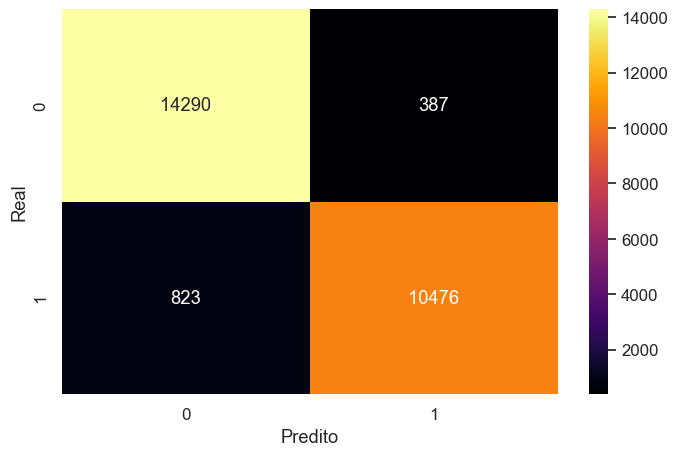

In [28]:
# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

In [29]:
X.columns

Index(['gender', 'customer_type', 'age', 'type_of_purchase', 'store_size',
       'store_distance', 'in_store_wifi', 'open/close_time_convenient',
       'easy_of_online_shopping', 'store_location', 'toilet_cleaning',
       'dressing_room', 'waiting_room', 'kids_entertainment', 'seller_service',
       'showroom', 'self_store', 'purchase_service', 'store_service',
       'cleanliness'],
      dtype='object')

# Retreino para submissão

In [30]:
df_test['carrier_delay_in_minutes'] = np.log1p(df_test['carrier_delay_in_minutes'])
df_test['delivery_delay_in_minutes'] = np.log1p(df_test['delivery_delay_in_minutes'])
df_test['store_distance'] = np.log1p(df_test['store_distance'])



df_test['grupo1'] = df_test['in_store_wifi'] + df_test['self_store'] + df_test['store_service'] + df_test['purchase_service'] + df_test['seller_service'] + df_test['kids_entertainment'] + df_test['store_location']
df_test['grupo2'] = df_test['open/close_time_convenient'] + df_test['dressing_room'] + df_test['waiting_room']
df_test['grupo3'] = df_test['cleanliness'] + df_test['toilet_cleaning'] + df_test['waiting_room']


bins = [0, 18, 35, 50, float('inf')]  # Faixas etárias
labels = ['1', '2', '3', '4']  # Rótulos para cada faixa etária
df_test['age_category'] = pd.cut(df_test['age'], bins=bins, labels=labels)

In [31]:
# Encoding a variavel target
catbin_vars = ['gender', 'customer_type', 'type_of_purchase']

le = LabelEncoder()
df_test[catbin_vars] = df_test[catbin_vars].apply(le.fit_transform)

# Encoding a variavel
lo = OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])
df_test['store_size'] = lo.fit_transform(df_test['store_size'].values.reshape(-1, 1))

In [32]:
# Retreino com o Pipeline do melhor resultado
pipe = result.best_estimator_
model = pipe.fit(X, y)

# predição
y_pred = model.predict(df_test)

In [33]:
y_pred

array([1, 1, 0, ..., 0, 1, 0])

In [34]:
# atribuição da predição para coluna 'Reserva Cancelada' da submissão
df_submission['Satisfaction'] = y_pred

# Salva o df_submission em .csv
df_submission.to_csv('submission7.csv', index=False)